# Material Clustering

**Sections:**
1. Imports & helper functions
2. Load Data
3. Data Cleaning
4. Feature Selection
5. Handle Missing Values & Normalization
6. Elbow & Silhouette analysis
7. Fit KMeans with recommended k and save cluster labels
8. PCA Visualisation
9. t-SNE Visualisation
10. Cluster Summaries & Interpretation
11. Cluster Profile Visualization

## 1) Imports & helper functions


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def plot_clusters_2d(X2d, labels, centroids_2d=None,
                     title="2D cluster plot",
                     xlabel="Component 1", ylabel="Component 2"):
    plt.figure(figsize=(8,6))
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        mask = labels == lab
        plt.scatter(X2d[mask, 0], X2d[mask, 1],
                    s=40, label=f"Cluster {lab}", alpha=0.75)
    if centroids_2d is not None:
        plt.scatter(centroids_2d[:,0], centroids_2d[:,1],
                    marker='X', s=200, c='red',
                    edgecolors='k', linewidths=1.2, label='Centroids')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

## 2) Load data


In [4]:

data_path = Path('/content/Data.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Data.csv not found at {data_path}. Please upload it to /content")

df = pd.read_csv(data_path)
print('Original shape:', df.shape)
df.head()

Original shape: (1552, 15)


,Std,ID,Material,Heat treatment,Su,Sy,A5,Bhn,E,G,mu,Ro,pH,Desc,HV
0,ANSI,D8894772B88F495093C43AF905AB6373,Steel SAE 1015,as-rolled,421,314,39.0,126.0,207000,79000,0.3,7860,NaN,NaN,NaN
1,ANSI,05982AC66F064F9EBC709E7A4164613A,Steel SAE 1015,normalized,424,324,37.0,121.0,207000,79000,0.3,7860,NaN,NaN,NaN
2,ANSI,356D6E63FF9A49A3AB23BF66BAC85DC3,Steel SAE 1015,annealed,386,284,37.0,111.0,207000,79000,0.3,7860,NaN,NaN,NaN
3,ANSI,1C758F8714AC4E0D9BD8D8AE1625AECD,Steel SAE 1020,as-rolled,448,331,36.0,143.0,207000,79000,0.3,7860,NaN,NaN,NaN
4,ANSI,DCE10036FC1946FC8C9108D598D116AD,Steel SAE 1020,normalized,441,346,35.8,131.0,207000,79000,0.3,7860,550.0,NaN,NaN


## 3) Data Cleaning


In [5]:
df = df.drop_duplicates()

for col in ['ID','Material','Heat treatment']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.strip()

def clean_numeric(series):
    return (series.astype(str)
            .str.replace(r'[^0-9.\-]', '', regex=True)
            .replace('', np.nan)
            .astype(float))

for col in ['Su','Sy','A5','Bhn','E','G']:
    if col in df.columns:
        df[col] = clean_numeric(df[col])

print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Std                  0
ID                   0
Material             0
Heat treatment     750
Su                   0
Sy                   0
A5                 206
Bhn               1089
E                    0
G                    0
mu                   0
Ro                   0
pH                1359
Desc               571
HV                1387
dtype: int64


## 4) Feature selection


In [6]:
meta_cols = ['ID', 'Material', 'Heat treatment']   # for reference
feature_cols = ['Su', 'Sy', 'A5', 'Bhn', 'E', 'G']

for col in feature_cols:
    if col not in df.columns:
        raise KeyError(f"Expected column {col} not found in CSV")

X_raw = df[feature_cols].copy()
print("Using fixed features:", feature_cols)
X_raw.describe()

Using fixed features: ['Su', 'Sy', 'A5', 'Bhn', 'E', 'G']


,Su,Sy,A5,Bhn,E,G
count,1552.000000,1552.000000,1346.000000,463.000000,1552.000000,1552.000000
mean,572.753222,387.010309,19.329421,177.138229,164571.520619,85598.840206
std,326.834927,289.482497,12.422004,113.508044,56135.405867,125326.800138
min,69.000000,28.000000,0.500000,19.000000,73000.000000,26000.000000
25%,340.000000,205.000000,11.000000,78.000000,105000.000000,40000.000000
50%,500.000000,305.000000,16.000000,170.000000,206000.000000,79000.000000
75%,705.000000,470.000000,24.375000,229.000000,206000.000000,80000.000000
max,2220.000000,2048.000000,70.000000,627.000000,219000.000000,769000.000000


## 5) Handle Missing Values & Normalization


In [7]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_raw)
X_scaled = scaler.fit_transform(X_imputed)

print("Preprocessed shape:", X_scaled.shape)

Preprocessed shape: (1552, 6)


## 6) Elbow & silhouette analysis


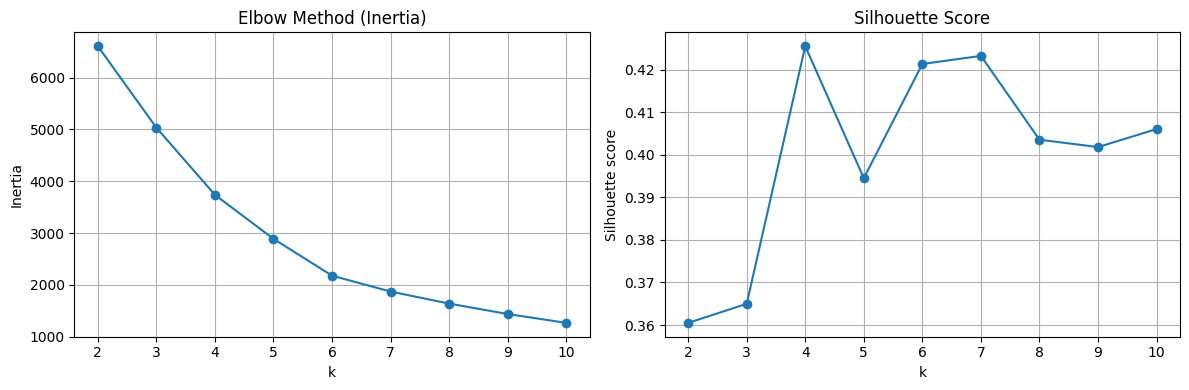

Recommended k by silhouette: 4


In [8]:
inertia = []
sil_scores = []
ks = list(range(2,11))

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labs))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print("Recommended k by silhouette:", best_k)

## 7) Fit KMeans with recommended k and save cluster labels




In [9]:
best_k = int(best_k)
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = km_final.fit_predict(X_scaled)

print("Cluster counts:\n", df['cluster'].value_counts())

out_path = Path('/content/Data_with_clusters.csv')
df.to_csv(out_path, index=False)
print("Saved labeled data to", out_path)

Cluster counts:
 cluster
1    874
0    521
2    109
3     48
Name: count, dtype: int64
Saved labeled data to /content/Data_with_clusters.csv


## 8) PCA visualization


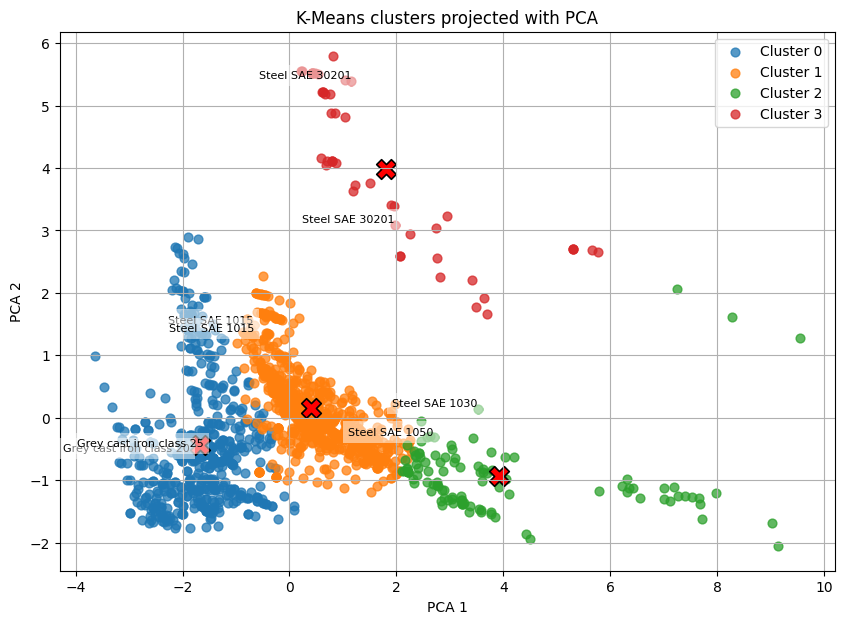

Saved PCA plot to /content/pca_clusters.png


In [10]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centroids_pca = pca.transform(km_final.cluster_centers_)

plt.figure(figsize=(10,7))
for cluster in np.unique(df['cluster']):
    mask = df['cluster'] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=40, label=f"Cluster {cluster}", alpha=0.75)

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker='X', s=200, c='red', edgecolors='k', linewidths=1.2)


for cluster in np.unique(df['cluster']):
    cluster_samples = df[df['cluster'] == cluster].head(2)
    for idx, row in cluster_samples.iterrows():
        px, py = X_pca[idx, 0], X_pca[idx, 1]
        plt.text(px, py, str(row['Material']), fontsize=8,
                 ha='right', va='bottom', color='black',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title("K-Means clusters projected with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.savefig('/content/pca_clusters.png', bbox_inches='tight')
plt.show()
print("Saved PCA plot to /content/pca_clusters.png")


## 9) t-SNE visualization


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


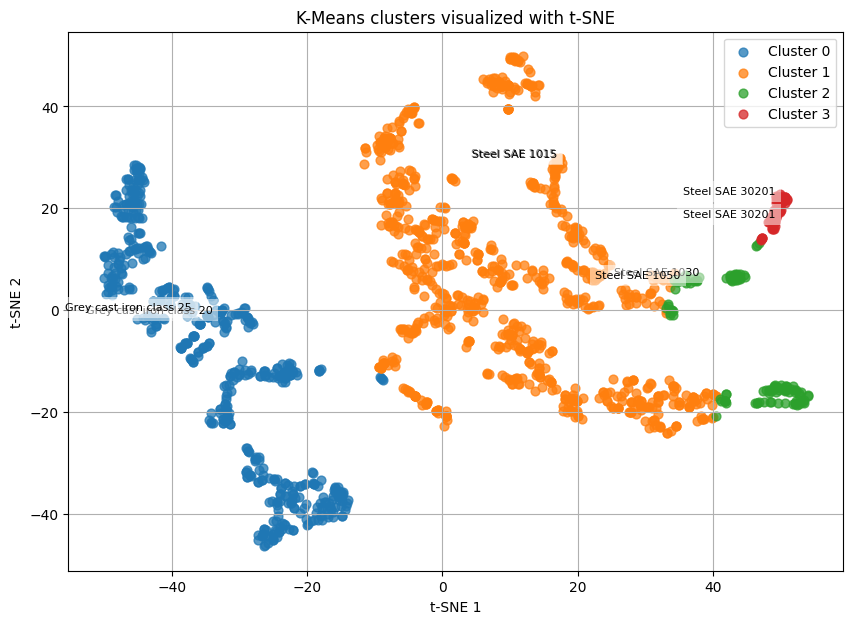

Saved t-SNE plot to /content/tsne_clusters.png


In [11]:
X_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000,
              random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(10,7))
for cluster in np.unique(df['cluster']):
    mask = df['cluster'] == cluster
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                s=40, label=f"Cluster {cluster}", alpha=0.75)

for cluster in np.unique(df['cluster']):
    cluster_samples = df[df['cluster'] == cluster].head(2)  # first 2 materials per cluster
    for idx, row in cluster_samples.iterrows():
        px, py = X_tsne[idx, 0], X_tsne[idx, 1]
        plt.text(px, py, str(row['Material']), fontsize=8,
                 ha='right', va='bottom', color='black',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title("K-Means clusters visualized with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.savefig('/content/tsne_clusters.png', bbox_inches='tight')
plt.show()
print("Saved t-SNE plot to /content/tsne_clusters.png")


## 10) Cluster Summaries & Interpretation


In [12]:
if 'Material' in df.columns:
    summary = df.groupby('cluster')['Material'].apply(lambda x: list(x.head(5)))
    print("\nTop 5 materials per cluster:")
    print(summary)

# Cluster profile summary
profile_cols = ['Su','Sy','A5','Bhn','E','G']
cluster_summary = df.groupby('cluster')[profile_cols].mean().round(2)
cluster_counts = df['cluster'].value_counts().sort_index()
cluster_summary['Count'] = cluster_counts.values

# Cluster Interpretation
interpretations = {}

for cluster, row in cluster_summary.iterrows():
    desc = []
    # Tensile strength
    if row['Su'] > cluster_summary['Su'].mean():
        desc.append("high tensile strength")
    else:
        desc.append("low tensile strength")
    # Ductility (elongation)
    if row['A5'] > cluster_summary['A5'].mean():
        desc.append("ductile (high elongation)")
    else:
        desc.append("brittle (low elongation)")
    # Hardness
    if row['Bhn'] > cluster_summary['Bhn'].mean():
        desc.append("hard material")
    else:
        desc.append("softer material")
    # Elastic modulus
    if row['E'] > cluster_summary['E'].mean():
        desc.append("stiffer (high E)")
    else:
        desc.append("less stiff (low E)")

    interpretations[cluster] = ", ".join(desc)

# Add interpretations as a new column
cluster_summary['Interpretation'] = cluster_summary.index.map(interpretations)

print("\nCluster Profile Summary with Interpretations:")
print(cluster_summary)

# Save combined summary to CSV
cluster_summary.to_csv('/content/cluster_summary_with_interpretations.csv')
print("Saved cluster summary with interpretations to /content/cluster_summary_with_interpretations.csv")


# Artifacts
print("\nArtifacts saved in /content:")
for f in ['Data_with_clusters.csv',
          'pca_clusters.png',
          'tsne_clusters.png',
          'cluster_summary.csv',
          'cluster_profiles.png',
          'silhouette_plot.png',
          'cluster_summary_with_interpretations.csv']:
    print("-", f)


Top 5 materials per cluster:
cluster
0    [Grey cast iron class 20, Grey cast iron class...
1    [Steel SAE 1015, Steel SAE 1015, Steel SAE 101...
2    [Steel SAE 1030, Steel SAE 1050, Steel SAE 106...
3    [Steel SAE 30201, Steel SAE 30201, Steel SAE 3...
Name: Material, dtype: object

Cluster Profile Summary with Interpretations:
              Su       Sy     A5     Bhn          E          G  Count  \
cluster                                                                 
0         303.52   194.33  19.91   75.59   88080.61   32549.71    521   
1         620.59   400.14  19.43  203.57  203276.89   78940.50    874   
2        1382.36  1165.39   8.61  401.35  206091.74   98522.94    109   
3         785.65   471.71  32.17  200.72  195770.83  753291.67     48   

                                            Interpretation  
cluster                                                     
0        low tensile strength, brittle (low elongation)...  
1        low tensile strength, brittle (low

## Cluster Profile Visualization


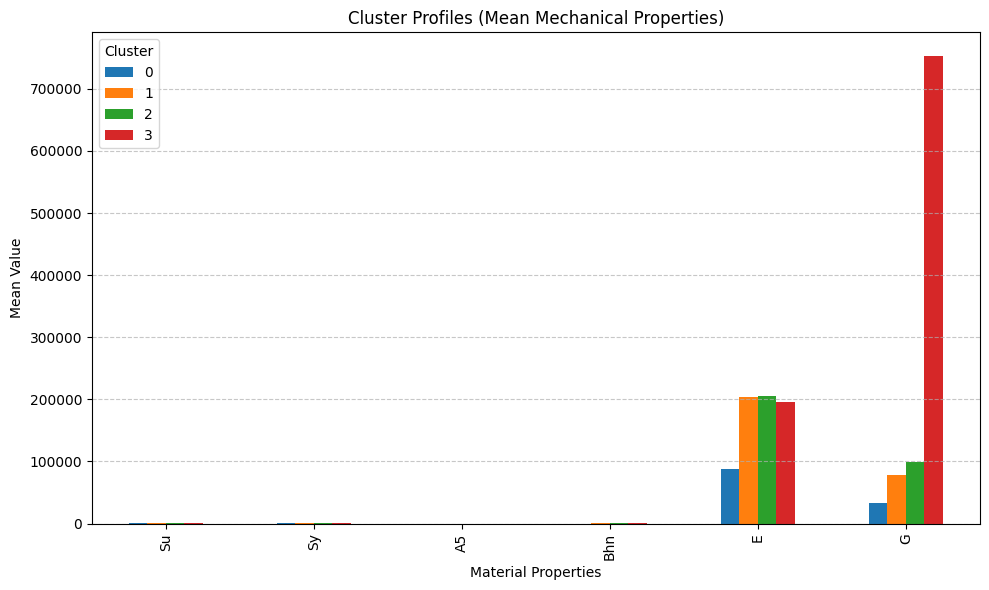

Saved cluster profile bar chart to /content/cluster_profiles.png


In [13]:
import matplotlib.pyplot as plt

profile_cols = ['Su','Sy','A5','Bhn','E','G']
cluster_summary = df.groupby('cluster')[profile_cols].mean().round(2)

cluster_summary.T.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Profiles (Mean Mechanical Properties)")
plt.xlabel("Material Properties")
plt.ylabel("Mean Value")
plt.legend(title="Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('/content/cluster_profiles.png', bbox_inches='tight')
plt.show()
print("Saved cluster profile bar chart to /content/cluster_profiles.png")